In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using KNN Classifier.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called KNN to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. For this problem we will consider a sample size of 10000 reviews sampled randomly from the original dataset. I have done this because I don't have a huge RAM size (12 GB to be specific). 
6. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
7. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [10]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import math
from sklearn.decomposition import TruncatedSVD

#### The immediate code block below does the following things :

1. Load the Amazon dataset.
2. Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.
3. Remove duplicate/redundant datas.
4. Get an idea of how much percentage data were actually duplicates.
5. Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.

###### NOTE : If we dont' clean the data and feed them to an ML system, it basically means we are throwing in a lot of garbage data to the ML system. If we give it garbage, it will give us garbage back. So it's utmost important to clean the data before proceeding.

In [11]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do nbot consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#### In this code block :

1. I am creating a copy of the final_data dataset called 'sampled_dataset' by dropping the unwanted columns that we don't need for this problem.
2. Sorting the data according to time, such that the oldest reviews are displayed at the top and the latest reviews are displayed at the bottom.
3. Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram.

The shape of the sampled dataset after dropping unwanted columns :  (364171, 4)

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0
1,1351209600,Very pleased with the quality of the espresso....,Positive,1
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1
7,1351209600,try it & we shared with the familys/all han th...,Positive,1
8,1351209600,If you like butter flavor this is the best mic...,Positive,1
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1


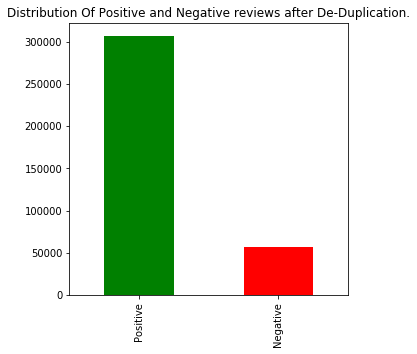

In [12]:
'''Creating a sampled dataset dropping the unwanted columns that we don't need for this problem, from the actual dataset.'''
#Creating a subset of the "final_data" table with randomly selecting 360000 samples
#sampled_dataset = final_data.sample(n=360000, replace=False, random_state=0).reset_index()
#print("\nThe shape of the sampled dataset : ", sampled_dataset.shape)

#Dropping unwanted columns for now.
sampled_dataset=final_data.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], axis=1)
print("The shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Display distribution of Postive and Negative reviews in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset (All the reviews are arranged according to time)
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

#### In this code block :

1. We define two functions which will remove the HTML tags and punctuations from each review.
2. At the end of this code block, each review will contain texts which will only contain alphabetical strings. 
3. We will apply techniques such as stemming and stopwords removal.
3. We will create two columns in the sampled dataset - 'CleanedText' and 'RemovedHTML'.
4. 'CleanedText' column will basically contain the data corpus after stemming the each reviews and removing stopwords from each review. We will use this for our Bag of Word model.
5. 'RemovedHTML' column will contain the data corpus from which only the HTML tags and punctuations are removed. We will use this column for our TF-IDF model, Average Word2Vec model and TF-IDF weighted average Word2Vec model.
6. Store the final table in a dataset called 'sampled_dataset' for future use.

In [13]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews.    
count=0                   #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
data_corpus=[]
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
stemed_word=''
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): #Checking if a word consists of only alphabets + word length is greater than 2.    
                if(cleaned_words.lower() not in custom_stopwords):
                    stemed_word=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(stemed_word)
                    if (sampled_dataset['SentimentPolarity'].values)[count] == 'Positive': 
                        all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
                    if(sampled_dataset['SentimentPolarity'].values)[count] == 'Negative':
                        all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
                else:
                    continue
            else:
                continue 
    string = " ".join(filtered_sentence) #Final string of cleaned words    
    data_corpus.append(string) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
    
print("The length of the data corpus is : {}".format(len(data_corpus)))

#Building a data corpus by removing only the Punctuations and HTML tags. Stopwords are preserved. Words are not stemmed. This is useful for Average Word2Vec, TF-IDF W2V.
string=' '    
not_stemmed_corpus=[]
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha()): #Checking if a word consists of only alphabets    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    string = " ".join(filtered_sentence)    
    not_stemmed_corpus.append(string) 
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['CleanedText']=data_corpus 

#Adding a column of PreserveStopwords to the table final which stores the data corpus in which stopwords are preserved and words are not stemmed.  
sampled_dataset['PreserveStopwords']=not_stemmed_corpus 

print("Printing the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

The length of the data corpus is : 364171
Printing the number of positive and negative reviews after data cleaning.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels,CleanedText,PreserveStopwords
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0,got coffe day ago coffe bean yesterday today m...,i just got this coffee a few days ago i had co...
1,1351209600,Very pleased with the quality of the espresso....,Positive,1,pleas qualiti espresso pod sturdi enough withs...,very pleased with the quality of the espresso ...
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1,bought new oster belgium waffl maker best waff...,bought this with my new oster belgium waffle m...
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0,drink lot tea world far worst tast tea purchas...,we drink a lot of tea from all over the world ...
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1,alway bought pure vanilla extract mexico got t...,i have always bought my pure vanilla extract i...
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1,label cadburi screme egg allergi inform manufa...,from the label on the cadbury screme egg aller...
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1,best soup mix tri love make soup best tast eas...,best soup mix i ve tried i love making soup an...
7,1351209600,try it & we shared with the familys/all han th...,Positive,1,tri share famili han thumb cut good lite oliv ...,try it we shared with the familys all han thum...
8,1351209600,If you like butter flavor this is the best mic...,Positive,1,like butter flavor best microwav popcorn avail...,if you like butter flavor this is the best mic...
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1,love sort tea friend know travel often bring t...,i love all sorts of teas my friends know this ...


### In this code block : 

1. We define a function which is used to seperate the positive and the negative data points for any input dataset using their corresponding class labels, using KNN algorithm.
2.We split the input dataset into train set and test set. For the training set I have taken the old 80% data. For the test set I have taken the latest 20% data. The idea here is to see how the model behaves when it's tested on 'new unseen' data after getting trained on an old data.
3. We use cross validation to determine the optimal value of K, and use this value of K as our number nearest neighbours to train the final model.
4. Finally, we will use accuracy as a metric to evaluate this models performance on unseen data.

In [4]:
def knn_algorithm(X_train, y_train, X_test, y_test, vectorizationType):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A 10 fold cross validation is performed on the train data and the value of optimal K is calculated. 
    The dataset is then trained with this value of optimal k. 
    Finally the knn model is used to predict its accuracy on the future unseen test set.'''
        
    X_train = X_train ; y_train = y_train #Train dataframe
    X_test = X_test ; y_test = y_test #Test Dataframe
    
    #algorithms = ['brute','kd_tree']
    algorithms = ['brute']
    
    for algo in algorithms:
                
        print("\nStarting Cross Validation steps for {} model using {} algorithm.".format(vectorizationType, algo.upper()))
        
        #Creating an odd number list of different K values for KNN.
        k_values = list(np.arange(1,50,2))

        #Create an empty list that will hold the mean of cross validation accuracy scores for each value of k in the CV step.
        cross_val_scores = []
        
        if algo == 'kd_tree':
            svd = TruncatedSVD(n_components = 100)
            X_train = svd.fit_transform(X_train)
            X_test = svd.fit_transform(X_test)
            
        #Perform 10-fold cross validation on the train set 
        for k in k_values:
            knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm=algo, p=2, metric='minkowski', n_jobs=6)
            accuracies = cross_val_score(knn_classifier, X_train, y_train, cv=10, scoring='accuracy')
            cross_val_scores.append(accuracies.mean())
            #print("Cross validation completed using k = {}".format(k))
        
        #Changing accuracy to error. **error = 1 - accuracy
        errors = [1 - x for x in cross_val_scores]

        #Determining best k from errors. K will be best for the lowest value for error.
        optimal_k = k_values[errors.index(min(errors))]
        print('\nThe optimal number of neighbors for {} algorithm is : {}'.format(algo.upper(),optimal_k))  

        #Plot errors vs k values
        plt.figure(figsize=(12,6))
        plt.plot(k_values , errors, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
        for xy in zip(k_values, np.round(errors,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        plt.title('Plot for Errors vs K Values')
        plt.xlabel('Number of Neighbors K for {} algorithm'.format(algo.upper()))
        plt.ylabel('Errors')
        plt.show()
    
        print("The error for each k value when using {} algorithm: {}".format(algo.upper(),np.round(errors,3)))


        '''Train the model using the optimal value of k found from the previous step and evaluate it's accuracy on the test set(unseen data).'''

        #Initialize the KNN model, where k = optimal_k
        knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance', algorithm='kd_tree', p=2, metric='minkowski', n_jobs=6)

        #Fit the model to the train set
        knn_classifier.fit(X_train, y_train)

        #Predict the labels for the test set.
        y_pred = knn_classifier.predict(X_test)

        '''PERFORMANCE EVALUATION'''

        print("\n'''PERFORMANCE EVALUATION FOR {} model'''".format(vectorizationType))

        print("\n\nDetailed report for the {} Vectorization using {} algorithm:".format(algo.upper(),vectorizationType))

        #Evaluate the accuracy of the model on test set
        test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
        points = accuracy_score(y_test, y_pred, normalize=False)
        print('The number of accurate predictions out of {} data points on unseen data for K = {} is {}'.format(X_test_vectors.shape[0],optimal_k, points))
        print('\nAccuracy of the KNN model using {} algorithm on unseen data for K = {} is {} %'.format(algo.upper(),optimal_k, np.round(test_accuracy,2)))

        #Get the precision, recall and F1 score for this model.
        print("Precision of the KNN model using {} algorithm on unseen data for K = {} is {}".format(algo.upper(),optimal_k, np.round(metrics.precision_score(y_test ,y_pred),4)))
        print("Recall of the KNN model using {} algorithm on unseen data for K = {} is {}".format(algo.upper(),optimal_k, np.round(metrics.recall_score(y_test ,y_pred),4)))
        print("F1 score of the KNN model using {} algorithm on unseen data for K = {} is {}".format(algo.upper(),optimal_k, np.round(metrics.f1_score(y_test ,y_pred),4)))

        #Classification Report
        print ('\nClasification report for {} model is using {} algorithm : \n'.format(vectorizationType,algo.upper()))
        print(metrics.classification_report(y_test,y_pred))

        #Inference
        print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
        print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))

        #Get the confusion matrix for the running model
        print("\nFind below the confusion matrix for {} model using {} algorithm.".format(vectorizationType,algo.upper()))
        sciplot.plot_confusion_matrix(y_test ,y_pred)
        
        #Save the below list for later use to display model information
        info_model_KNN = [vectorizationType, optimal_k, np.round(np.array(errors).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4)]
        with open('info_model_KNN.txt', 'a') as filehandle:  
            filehandle.writelines("%s " % iterator for iterator in info_model_KNN)
            filehandle.writelines("\n")
            
        #Freeing memory allocations    
        del(X_train, y_train, X_test, y_test, y_pred, knn_classifier)

### KNN on the Bag of Words model created using 'CleanedText'.

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms.
The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.

Let's look at this example of 2 reviews below :

r1 = {"The food is great, ambience is great"} and  </br>r2 = {"I love this food"}

At first the words will be extracted from r1 and r2.

r1' = {"The", "food", "is", "great", "ambience", "is", "great"} and r2' = {"I", "love", "this", "food"}

Now using r1' and r2' we will create a vector of unique words -> V =  {"The", "food", "is", "great", "ambience", "I", "love", "this"}

Now here's how the vector representation will look like for each reviews r1 and r2, when we make use of the vector 'V' created above.

r1_vector = [1,1,2,2,1,0,0,0] and r2_vector = [0,1,0,0,0,1,1,1]

In r1 since, "great" and "is" occurs twice, we have set the count to 2. If a words doesn't occur in a review we will set the count to 0. Although "is" a stopword, the example above is intended to make you understand how bag of words work.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (40000, 24218)
The shape of the X_test_vectors is : (10000, 24218)

Starting Cross Validation steps for Bag-of-Words model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 7


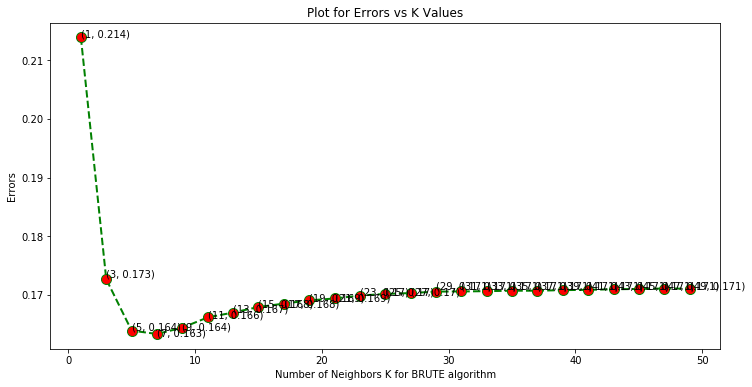

The error for each k value when using BRUTE algorithm: [0.214 0.173 0.164 0.163 0.164 0.166 0.167 0.168 0.168 0.169 0.169 0.17
 0.17  0.17  0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171
 0.171]

'''PERFORMANCE EVALUATION FOR Bag-of-Words model'''


Detailed report for the BRUTE Vectorization using Bag-of-Words algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 7 is 8302

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 7 is 83.02 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 7 is 0.8346
Recall of the KNN model using BRUTE algorithm on unseen data for K = 7 is 0.9897
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 7 is 0.9055

Clasification report for Bag-of-Words model is using BRUTE algorithm : 

             precision    recall  f1-score   support

          0       0.66      0.09      0.16      1778
          1       0.83      0.99      0.91      8222

av

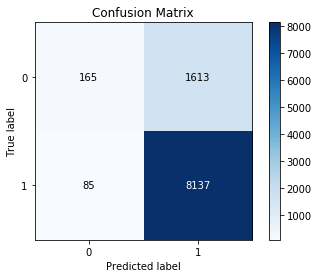

In [5]:
'''Creating the Bag of Words vector for the cleaned reviews.'''
#Bag of Words model creation using cleaned text 

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations.
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the KNN to the BOW model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words")

### KNN on the TF-IDF model created using 'CleanedText' texts. 

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review.
For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector. 

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (40000, 24218)
The shape of the X_test_vectors is : (10000, 24218)

Starting Cross Validation steps for TF-IDF model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 5


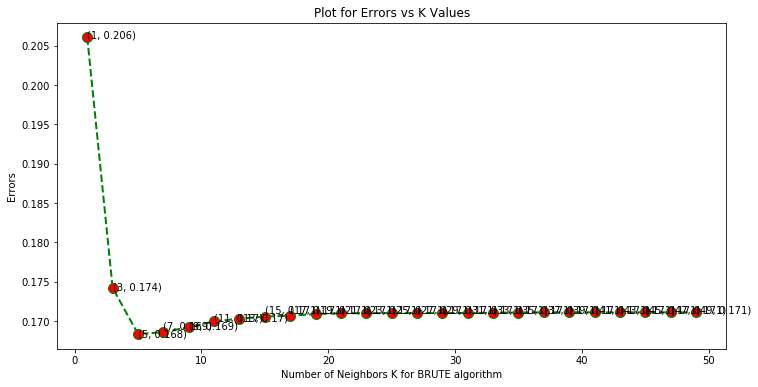

The error for each k value when using BRUTE algorithm: [0.206 0.174 0.168 0.169 0.169 0.17  0.17  0.171 0.171 0.171 0.171 0.171
 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171 0.171
 0.171]

'''PERFORMANCE EVALUATION FOR TF-IDF model'''


Detailed report for the BRUTE Vectorization using TF-IDF algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 5 is 8241

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 5 is 82.41 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 5 is 0.8294
Recall of the KNN model using BRUTE algorithm on unseen data for K = 5 is 0.9897
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 5 is 0.9025

Clasification report for TF-IDF model is using BRUTE algorithm : 

             precision    recall  f1-score   support

          0       0.55      0.06      0.11      1778
          1       0.83      0.99      0.90      8222

avg / total       0

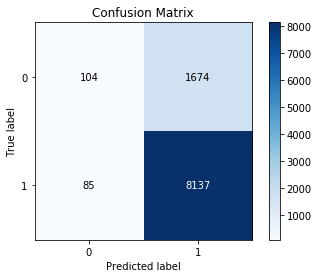

In [6]:
'''TF-IDF model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = tf_idf_object.transform(X_train)
X_test_vectors = tf_idf_object.transform(X_test)

#Colum Standardization of the TF-IDF vector created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations.
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the KNN to the TF-IDF model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF")

### KNN on the Average Word2Vec using a 100 dimensional vector representation of each word.

In this model we convert each word present in a review to vectors. For each sentence we will compute the average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will convert each word to a vector, sum them up and divide by the total number of words (N) present in that particular sentence. So our final vector will look like (1/N) * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

The size of the Word2Vec text corpus :  40000

The number of words that occured minimum 5 times :  12387

The length of the sentence vectors : 40000

Size of each vector :  200
The size of the Word2Vec text corpus :  10000

The number of words that occured minimum 5 times :  6457

The length of the sentence vectors : 10000

Size of each vector :  200
The shape of the X_train_vectors is : (40000, 200)
The shape of the X_test_vectors is : (10000, 200)

Starting Cross Validation steps for Average-Word2Vec model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 15


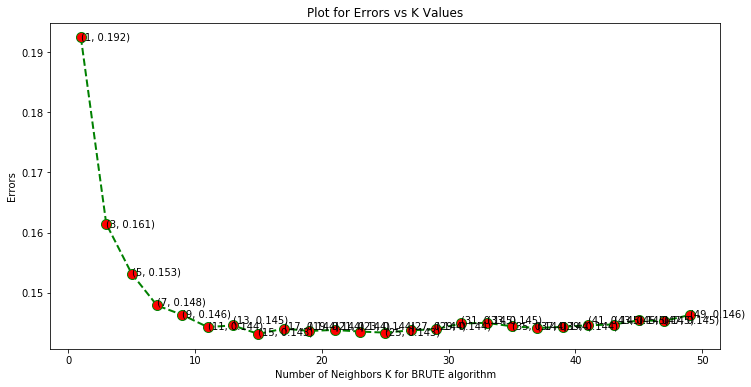

The error for each k value when using BRUTE algorithm: [0.192 0.161 0.153 0.148 0.146 0.144 0.145 0.143 0.144 0.144 0.144 0.144
 0.143 0.144 0.144 0.145 0.145 0.144 0.144 0.144 0.145 0.145 0.145 0.145
 0.146]

'''PERFORMANCE EVALUATION FOR Average-Word2Vec model'''


Detailed report for the BRUTE Vectorization using Average-Word2Vec algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 15 is 4974

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 15 is 49.74 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 15 is 0.8706
Recall of the KNN model using BRUTE algorithm on unseen data for K = 15 is 0.4566
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 15 is 0.599

Clasification report for Average-Word2Vec model is using BRUTE algorithm : 

             precision    recall  f1-score   support

          0       0.21      0.69      0.33      1778
          1       0.87      0.46      0

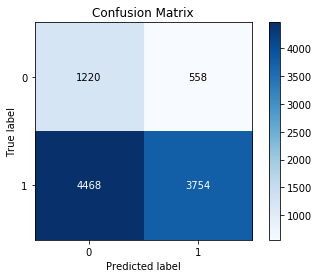

In [7]:
'''KNN using the average word2vec model on the Amazon dataset, using a 100 dimensional vector representation of each word.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]


#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize(dataset):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
    print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))
    
    #min_count = 5 considers only those words for our model which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6)
    word2vec_words = list(word2vec_model.wv.vocab)
    print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in word2vec_corpus: #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    print("\nThe length of the sentence vectors :",len(sent_vectors))
    print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors

X_train_vectors = vectorize(X_train)
X_test_vectors = vectorize(X_test)

#Colum Standardization of the average word2vec vector created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations.
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the KNN to the Average Word2Vec model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Average-Word2Vec")

### KNN on the TF-IDF weighted Average Word2Vec representation on the reviews.

In this model we convert each word present in a review to vectors. For each sentence we will compute the tf-idf average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will compute the tf-idf for each word in a review for all reviews. Lets say the corresponding tf-idfs are {t1,t2,t3,t4,t5,t6......tN}. We will convert each word to a vector, sum them up and divide by the summation of tf-idf vectors for all words present in that particular sentence. So our final vector will look like [1/(t1+t2+t3+t4+t5+t6+ ..... +tN)] * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

The shape of the X_train_vectors is : (40000, 200)
The shape of the X_test_vectors is : (10000, 200)

Starting Cross Validation steps for TF-IDF-Average-Word2Vec model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 17


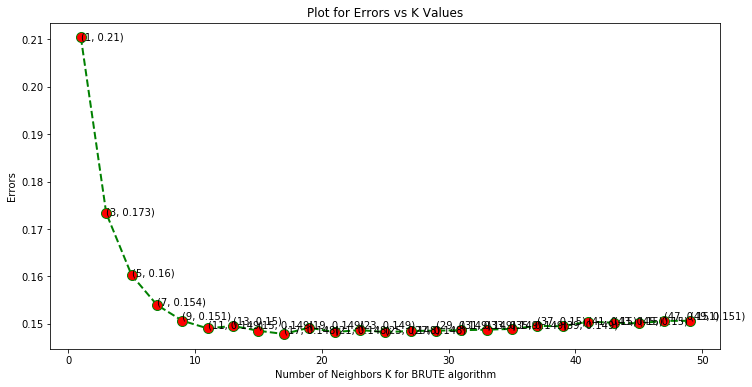

The error for each k value when using BRUTE algorithm: [0.21  0.173 0.16  0.154 0.151 0.149 0.15  0.149 0.148 0.149 0.148 0.149
 0.148 0.148 0.149 0.149 0.149 0.149 0.15  0.149 0.15  0.15  0.15  0.151
 0.151]

'''PERFORMANCE EVALUATION FOR TF-IDF-Average-Word2Vec model'''


Detailed report for the BRUTE Vectorization using TF-IDF-Average-Word2Vec algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 17 is 8214

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 17 is 82.14 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 17 is 0.8221
Recall of the KNN model using BRUTE algorithm on unseen data for K = 17 is 0.999
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 17 is 0.9019

Clasification report for TF-IDF-Average-Word2Vec model is using BRUTE algorithm : 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1778
          1       

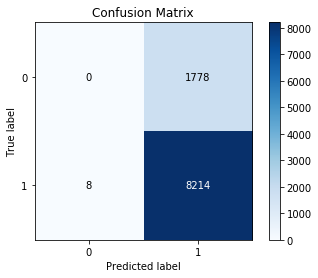

In [8]:
'''KNN using TF-IDF weighted Average Word2Vec model on the Amazon dataset.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize(dataset, fit_dataset):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #min_count = 5 considers only those words which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6)
    word2vec_words = list(word2vec_model.wv.vocab)

    #Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
    tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(fit_dataset)
    final_tf_idf_vectors = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in word2vec_corpus: #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum =0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = final_tf_idf_vectors[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review
                sent_vec += (word_vectors * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

X_train_vectors = vectorize(X_train, X_train)
X_test_vectors = vectorize(X_test, X_train)

#Colum Standardization of the TF-IDF Average Word2Vec vectors created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations. 
del(X, y, X_train, X_test, sampled_dataset)

#Fitting the KNN to the TF-IDF Average Word2Vec model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF-Average-Word2Vec")

In [9]:
#Display information in a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (K=)", "Train Error", "Test Error", "F1-Score"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_KNN.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+-------------------------+-----------------------------+-------------+------------+----------+
|          Model          |  Hyper-Parameter Value (K=) | Train Error | Test Error | F1-Score |
+-------------------------+-----------------------------+-------------+------------+----------+
|       Bag-of-Words      |              7              |    0.171    |   0.1698   |  0.9055  |
|          TF-IDF         |              5              |    0.1722   |   0.1759   |  0.9025  |
|     Average-Word2Vec    |              15             |    0.1475   |   0.5026   |  0.599   |
| TF-IDF-Average-Word2Vec |              17             |    0.1533   |   0.1786   |  0.9019  |
+-------------------------+-----------------------------+-------------+------------+----------+


As we can see, the most robust model is the TF-IDF weighted Word2Vec model where the train and test errors are relatively lower than the other models. 